### House Price Regression and Feature Engineering

This was a very interesting competition because of how much I learned through trial and error, and from practicing all the different regression methods/techniques.

I submitted over 100 times, and about 50% of my submissions were just to understand which methods worked better. Once that was done I started tuning the parameters, adding more features and ensembling.

**Public score: 0.11819**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: "%3f"%x)
%matplotlib inline

In [2]:
train = pd.read_csv("../data/houseprices/train.csv")

train_shape = train.shape[0]

train.shape

(1460, 81)

In [3]:
test = pd.read_csv("../data/houseprices/test.csv")
test.shape

(1459, 80)

In [4]:
all_data_columns = test.columns

y = train.SalePrice
train = train[all_data_columns]

all_data = pd.concat([train, test])

In [5]:
all_data.shape

(2919, 80)

### Preprocessing

In [6]:
# log transform the sale price
y = np.log1p(y)

#### Steps to clean up the data

1. Replace the empty/NaN values with more relevant values than mean or median where applicable
2. Fix up categorical and ordinal data - convert to categorical or numerical 
3. Group larger categories into smaller number of categories - and turn them into ranks (1,2,3 = 1, 4,5,6 = 2 etc) - using pd.cut?
4. Feature engineering - create new features based off the grouped categories (1*x, 2*x where x is related feature)
5. Find the most important features and create new features by weighting them much higher (^2, ^3)

In [7]:
# 1

# Data that needs good replacement of NaNs
nan_data = all_data.isnull().sum().sort_values(ascending=False)
nan_data[nan_data > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

In [8]:
# 1

all_data.PoolQC.fillna('NA', inplace=True)
all_data.MiscFeature.fillna('NA', inplace=True)
all_data.Alley.fillna('NA', inplace=True)
all_data.Fence.fillna('NA', inplace=True)
all_data.FireplaceQu.fillna('NA', inplace=True)
all_data.LotFrontage.fillna(0., inplace=True)
all_data.GarageCond.fillna('NA', inplace=True)
all_data.GarageType.fillna('NA', inplace=True)
all_data.GarageFinish.fillna('NA', inplace=True)
all_data.GarageQual.fillna('NA', inplace=True)
all_data.BsmtExposure.fillna('NA', inplace=True)
all_data.BsmtFinType2.fillna('NA', inplace=True)
all_data.BsmtFinType1.fillna('NA', inplace=True)
all_data.BsmtCond.fillna('NA', inplace=True)
all_data.BsmtQual.fillna('NA', inplace=True)
all_data.MasVnrType.fillna('None', inplace=True)
all_data.MasVnrArea.fillna(0, inplace=True)

all_data.GarageArea.fillna(0, inplace=True)
all_data.BsmtUnfSF.fillna(0, inplace=True)
all_data.BsmtFinSF2.fillna(0, inplace=True)
all_data.BsmtFullBath.fillna(0, inplace=True)
all_data.BsmtHalfBath.fillna(0, inplace=True)
all_data.BsmtFinSF1.fillna(0, inplace=True)
all_data.KitchenQual.fillna('TA', inplace=True)
all_data.Functional.fillna(0, inplace=True)
all_data.Utilities.fillna(0, inplace=True)
all_data.MSZoning.fillna(0, inplace=True)
all_data.Exterior2nd.fillna(all_data.Exterior2nd.mode().values[0], inplace=True)
all_data.Electrical.fillna(all_data.Electrical.mode().values[0], inplace=True)
all_data.Exterior1st.fillna(all_data.Exterior1st.mode().values[0], inplace=True)
all_data.GarageCars.fillna(0, inplace=True)
all_data.TotalBsmtSF.fillna(0, inplace=True)
all_data.SaleType.fillna(all_data.SaleType.mode().values[0], inplace=True)
all_data.GarageType.fillna("NoGarage", inplace=True)

In [9]:
# leaving these as None is the best value for it - not missing data - just not applicable
nan_data = all_data.isnull().sum().sort_values(ascending=False)
nan_data[nan_data > 0]

GarageYrBlt    159
dtype: int64

In [10]:
# 2

# Converting categorical data with numerical features into categories 
# NOTE:- pd.get_dummies will one hot encode these columns now
# MSSubClass, MoSold
all_data['MSSubClass'] = all_data.MSSubClass.astype('category')
all_data['MoSold'] = all_data.MoSold.astype('category')
all_data['GarageYrBlt'] = all_data.GarageYrBlt.astype('category')

all_data['LotConfig'] = all_data.LotConfig.astype('category')
all_data['Neighborhood'] = all_data.Neighborhood.astype('category')
all_data['Condition1'] = all_data.Condition1.astype('category')
all_data['BldgType'] = all_data.BldgType.astype('category')
all_data['HouseStyle'] = all_data.HouseStyle.astype('category')
all_data['RoofStyle'] = all_data.RoofStyle.astype('category')
all_data['Exterior1st'] = all_data.Exterior1st.astype('category')
all_data['MasVnrArea'] = all_data.MasVnrArea.astype('category')

all_data['Foundation'] = all_data.Foundation.astype('category')
all_data['SaleCondition'] = all_data.SaleCondition.astype('category')
all_data['SaleType'] = all_data.SaleType.astype('category')
all_data['Exterior2nd'] = all_data.Exterior2nd.astype('category')

In [11]:
# 2

# Converting categoricaldata with non-numerical features with rank into ordinal categories
# ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual
# Functional, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence, Alley, LotShape, Utilities, LotConfig,
# LandContour, LandSlope
all_data['ExterQual'] = all_data.ExterQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
all_data['ExterCond'] = all_data.ExterCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
all_data['BsmtQual'] = all_data.BsmtQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
all_data['BsmtCond'] = all_data.BsmtCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
all_data['BsmtExposure'] = all_data.BsmtExposure.replace(dict(Gd=4, Av=3, Mn=2, No=1, NA=0))
all_data['BsmtFinType1'] = all_data.BsmtFinType1.replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
all_data['BsmtFinType2'] = all_data.BsmtFinType2.replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
all_data['HeatingQC'] = all_data.HeatingQC.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
all_data['KitchenQual'] = all_data.KitchenQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
all_data['Functional'] = all_data.Functional.replace(dict(Typ=8, Min1=7, Min2=6, Mod=5, Maj1=4, Maj2=3, Sev=2, Sal=1))
all_data['FireplaceQu'] = all_data.FireplaceQu.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
all_data['GarageQual'] = all_data.GarageQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
all_data['GarageCond'] = all_data.GarageCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
all_data['PoolQC'] = all_data.PoolQC.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, NA=1))
all_data['Fence'] = all_data.Fence.replace(dict(GdPrv=5, MnPrv=4, GdWo=3, MnWw=2, NA=1))
all_data['Alley'] = all_data.Alley.replace(dict(Grvl=3, Pave=2, NA=1))
all_data['CatLotShape'] = all_data.LotShape.replace(dict(Reg=4, IR1=3, IR2=2, IR3=1))
all_data['Utilities'] = all_data.Utilities.replace(dict(AllPub=4, NoSewr=3, NoSeWa=2, ELO=1))
all_data['LotConfig'] = all_data.LotConfig.replace(dict(Inside=5, Corner=4, CulDSac=3, FR2=2, FR3=1))
all_data['CatLandContour'] = all_data.LandContour.replace(dict(Lvl=4, Bnk=3, HLS=2, Low=1))
all_data['CatLandSlope'] = all_data.LandSlope.replace(dict(Gtl=3, Mod=2, Sev=1))

In [12]:
# 3

# Create new features
# Simplify existing features - squash into smaller groups
# existing features
all_data['OverallQual_simple'] = all_data.OverallQual.replace({1:1, 2:1, 3:1, # bad quality
                                                        4:2, 5:2, 6:2, # mediocre quality
                                                        7:3, 8:3, 9:3, 10:3 # good quality
                                                       })
all_data['OverallCond_simple'] = all_data.OverallCond.replace({1:1, 2:1, 3:1, # bad quality
                                                        4:2, 5:2, 6:2, # mediocre quality
                                                        7:3, 8:3, 9:3, 10:3 # good quality
                                                       })
# convert from categorical to ordinal with smaller groups
all_data['ExterQual_simple'] = all_data.ExterQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['ExterCond_simple'] = all_data.ExterCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['BsmtQual_simple'] = all_data.BsmtQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['BsmtCond_simple'] = all_data.BsmtCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['BsmtFinType1_simple'] = all_data.BsmtFinType1.replace({6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
all_data['BsmtFinType2_simple'] = all_data.BsmtFinType2.replace({6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
all_data['HeatingQC_simple'] = all_data.HeatingQC.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['KitchenQual_simple'] = all_data.KitchenQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['Functional_simple'] = all_data.Functional.replace({8:4, 7:3, 7:3, 6:3, 5:2,4:2, 3:1, 2:1})
all_data['GarageQual_simple'] = all_data.GarageQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['GarageCond_simple'] = all_data.GarageCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['PoolQC_simple'] = all_data.PoolQC.replace({5:3, 4:3, 3:2, 2:2, 1:1})
all_data['FireplaceQu_simple'] = all_data.FireplaceQu.replace({5:3, 4:3, 3:2, 2:2, 1:1})


In [13]:
# Create new features from existing data
all_data['TotalBath'] = all_data.FullBath + all_data.BsmtFullBath + 0.5 * (all_data.BsmtHalfBath + all_data.HalfBath)
all_data['TotalSF'] = all_data.TotalBsmtSF + all_data.GrLivArea

In [14]:
all_data["IsRegularLotShape"] = (all_data.LotShape == "Reg") * 1
all_data["IsLandLevel"] = (all_data.LandContour == "Lvl") * 1
all_data["IsLandSlopeGntl"] = (all_data.LandSlope == "Gtl") * 1
all_data["IsElectricalSBrkr"] = (all_data.Electrical == "SBrkr") * 1
all_data["IsGarageDetached"] = (all_data.GarageType == "Detchd") * 1
all_data["IsPavedDrive"] = (all_data.PavedDrive == "Y") * 1
all_data["HasShed"] = (all_data.MiscFeature == "Shed") * 1

In [15]:
# these features jumped my score from 0.11875 to 0.11833

all_data.loc[all_data.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
all_data["Neighborhood_Good"].fillna(0, inplace=True)

In [16]:
# jumped the score from 0.11833 to 0.11819
all_data["SaleCondition_PriceDown"] = all_data.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
all_data["BoughtOffPlan"] = all_data.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})


area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
all_data["TotalArea"] = all_data[area_cols].sum(axis=1)

In [17]:
# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
all_data["Remodeled"] = (all_data["YearRemodAdd"] != all_data["YearBuilt"]) * 1

# Did a remodeling happen in the year the house was sold?
all_data["RecentRemodel"] = (all_data["YearRemodAdd"] == all_data["YrSold"]) * 1

In [18]:
all_data["Age"] = 2010 - all_data["YearBuilt"]
all_data["TimeSinceSold"] = 2010 - all_data["YrSold"]

In [19]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = all_data.select_dtypes(include = ["object", "category"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object", "category"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

Numerical features : 86
Categorical features : 29


In [20]:
all_data_num.isnull().values.sum(), all_data_cat.isnull().values.sum()

(0, 159)

In [21]:
# need to log_transform the skewed features to reduce impact of outliers

skewness = all_data_num.apply(skew)
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
all_data_num[skewed_features] = all_data_num[skewed_features].applymap(np.log1p)

/home/vathsala/.local/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [22]:
# One hot encoding the categorical variables

all_data_cat = pd.get_dummies(all_data_cat)

### Modeling

- concat all data and scale - split to train and test
- split train set to tr and val for training and validation

- run GridSearchCV to get XGBoost parameters on tr and test on val


In [23]:
all_data = pd.concat([all_data_num, all_data_cat], axis=1)

scaler = StandardScaler()
all_data[numerical_features] = scaler.fit_transform(all_data[numerical_features])

X_train = all_data[:train_shape]
X_test = all_data[train_shape:]
print X_train.shape, X_test.shape

(1460, 837) (1459, 837)


In [24]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state=3)
X_tr = X_tr.as_matrix()
X_val = X_val.as_matrix()
X_tr.shape, X_val.shape

((1095, 837), (365, 837))

#### Ridge

In [25]:
model_ridge = Ridge(alpha=22)
model_ridge.fit(X_train, y)

preds_r = model_ridge.predict(X_test)

ridge_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_r), Id=test.Id))

#### Lasso

In [26]:
model_lasso = Lasso(alpha=0.00055)
model_lasso.fit(X_train, y)

preds_l = model_lasso.predict(X_test)

lasso_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_l), Id=test.Id))

### XGBoost

In [27]:
import xgboost as xgb

regr = xgb.XGBRegressor(colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

# TODO use gridsearch to get the values for the values above

/home/vathsala/anaconda2/envs/rnd/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
regr.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1.5, missing=None, n_estimators=7200, nthread=-1,
       objective='reg:linear', reg_alpha=0.9, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.2)

In [30]:
regr.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1.5, missing=None, n_estimators=7200, nthread=-1,
       objective='reg:linear', reg_alpha=0.9, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.2)

In [31]:
y_pred_xgb = regr.predict(X_test)

### Ensembling

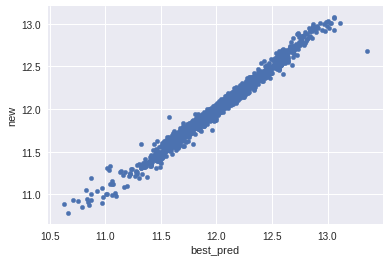

In [32]:
# residuals from best performing method for validation
pred_to_plot = pd.DataFrame(dict(best_pred=preds_l, new=y_pred_xgb))
pred_to_plot.plot(x='best_pred', y='new', kind='scatter')

In [33]:
preds_c1 = 0.3 * preds_l + 0.4 * preds_r + 0.3 * y_pred_xgb

comb_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_c1), Id=test.Id))
comb_preds.to_csv('./submission_comb_lrx.csv', index=False)

**Sources: **

- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
- https://www.kaggle.com/humananalog/xgboost-lasso/code
- http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/
- http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova